In [1]:
import json
import os
import PIL
import PIL.Image
from IPython.display import display
from PIL import Image

import keras
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np



# Import all the Keras machinery we need
from keras import applications
from keras import optimizers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras import metrics

Using TensorFlow backend.


In [2]:
# Prepare our training / validation / etc set
def getData():
    filename = './dataset/majurca-ecoclassifier-assets.json'
    im_path = []
    labels = []
    k=0

    #Read JSON data into the datastore variable
    if filename:
        with open(filename, 'r') as f:
            list_info = json.load(f)

    str_filter = '192-168-0-31' # to filter certain files
    #print(list_info[2443]['id'])
    #print(len(list_info))

    for dict in list_info:
        #print(k)
        if str_filter in dict['path']:
            if dict['tag_slugs'] != [] and dict['tag_slugs'] in [['godet-vide'], ['pet-fonce'], ['pet-clair']]:
                labels.append(dict['tag_slugs'][0])
                str = dict['thumbnail_320x200_path']
                str = str.replace(':','_')
                im_path.append(str)
            else:
                #print('no label',dict['path'])
                k=k+1
        else:
            #print('wrong camera',dict['path'])
            k=k+1

    print('{} images were ignored'.format(k))
    print(len(im_path),len(labels))
    return im_path, labels

def splitData(X,y):
    output_dir = './dataset_split'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    #Create folder for the test and training split
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)
        os.mkdir(output_dir + '/test')
        os.mkdir(output_dir + '/train')
    else:
        print("Warning: output dir {} already exists".format(output_dir))

    #Copying files into test and train folder
    label_count_test = []
    label_count_train = []

    for file in X_test:
        #file = file.replace(':','_')
        os.system('cp ./dataset/'+ file + ' ' + output_dir + '/test/' + file)

    for file in X_train:
        #file = file.replace(':','_')
        os.system('cp ./dataset/'+ file + ' ' + output_dir + '/train/' + file)

    #print(Counter(y_train), Counter(y_test))
    return X_train, X_test, y_train, y_test

'''
def splitValidation(X,y):
    X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_vali, y_train, y_vali
'''

files_all, labels_all = getData()
#print(type(files_all[3]),labels_all[3])
X, X_test, y, y_test = splitData(files_all,labels_all)
#X_train, X_vali, y_train, y_vali = splitValidation(X_try, y_try)
print(X[1])

1755 images were ignored
725 725
wsEN4iv2SliFUuYNXIM-5Q_R_J1rDtrS0GVg5P_Teq5wQ_320x200.png


In [3]:
# We build our (X, y) set. We ignore test set yet (laziness)


'''
with open("./dataset/majurca-ecoclassifier-assets.json", "r") as source:
    assets = json.load(source)
    
# Populate our target variables. X is gonna be filename, y the class
X = []
y = []
target_labels = set(("pet-clair", "pet-fonce", "godet-vide", ))
for asset in assets:
    # Skip what's not from OUR camera
    if not "192-168-0-31" in asset['path']:
        continue
    intersection = target_labels.intersection(asset['tag_slugs'])
    if not intersection:
        continue
    label = intersection.pop()
    str = asset['thumbnail_320x200_path']
    str = str.replace(':','_')
    X.append("./dataset/{}".format(str))
    y.append(label)
print(X[1])
'''

./dataset/wsEN4iv2SliFUuYNXIM-5Q_mN01z2Y0RASRi1KBB0tY2Q_320x200.png


In [3]:
n_train_samples = len(X) * 0.8
n_val_samples = len(X) * 0.2
batch_size = 32
target_labels = y
datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)
dataset_info = {'filename': X, 'class': y}
dataframe = pd.DataFrame(dataset_info)
dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe,
    directory="./dataset_split/train/",
    subset="training",
    class_mode="categorical",
    classes=target_labels,
    target_size=(224, 224),
    batch_size=batch_size,
)
validation_generator = datagen.flow_from_dataframe(
    dataframe,
    directory="./dataset_split/train/",
    subset="validation",
    class_mode="categorical",
    classes=target_labels,
    target_size=(224, 224),
    batch_size=batch_size,
)


Found 464 images belonging to 3 classes.
Found 116 images belonging to 3 classes.


In [4]:
train_generator.class_indices

{'godet-vide': 0, 'pet-clair': 1, 'pet-fonce': 2}

In [11]:
# SOLUTION 3 VGG16 simple sans préentrainement du top classifier

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense



# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape = (224,224,3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(3, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning

#top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:10]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
metrics=['accuracy'])

#K.clear_session()

history = model.fit_generator(
    train_generator,
    steps_per_epoch=n_train_samples // batch_size,
    epochs=6,
    validation_data=validation_generator,
    validation_steps=n_val_samples // batch_size)

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/6
14/14 [==============================] - 20s 1s/step - loss: 1.0222 - acc: 0.4330 - val_loss: 0.8770 - val_acc: 0.5104
Epoch 2/6
14/14 [==============================] - 19s 1s/step - loss: 0.7740 - acc: 0.6343 - val_loss: 0.6821 - val_acc: 0.7262
Epoch 3/6
14/14 [==============================] - 12s 877ms/step - loss: 0.5811 - acc: 0.7476 - val_loss: 0.4452 - val_acc: 0.8452
Epoch 4/6
14/14 [==============================] - 12s 870ms/step - loss: 0.3958 - acc: 0.8416 - val_loss: 0.2837 - val_acc: 0.9762
Epoch 5/6
14/14 [==============================] - 12s 877ms/step - loss: 0.2543 - acc: 0.9041 - val_loss: 0.1928 - val_acc: 0.9375
Epoch 6/6
14/14 [==============================] - 12s 872ms/step - loss: 0.1778 - acc: 0.9420 - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
0.9404761876378741


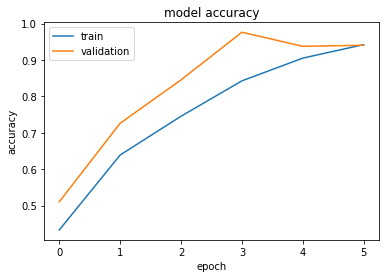

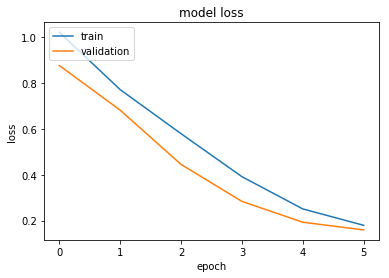

In [12]:
model.save('vgg16_v3.h5')
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
print(history.history['val_acc'][-1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
# Avec K-Fold CROSS VALIDATION ( a faire)
'''
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    model.fit_generator(
                train_generator,
                steps_per_epoch=n_train_samples // batch_size,
                epochs=6,
                validation_data=validation_generator,
                validation_steps=n_val_samples // batch_size,
)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
# Leeeet's traaaaaaaaiiiiin!!!!
'''

'\nfor j, (train_idx, val_idx) in enumerate(folds):\n    \n    print(\'\nFold \',j)\n    X_train_cv = X_train[train_idx]\n    y_train_cv = y_train[train_idx]\n    X_valid_cv = X_train[val_idx]\n    y_valid_cv= y_train[val_idx]\n    \n    name_weights = "final_model_fold" + str(j) + "_weights.h5"\n    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)\n    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)\n    model = get_model()\n    model.fit_generator(\n                generator,\n                steps_per_epoch=len(X_train_cv)/batch_size,\n                epochs=15,\n                shuffle=True,\n                verbose=1,\n                validation_data = (X_valid_cv, y_valid_cv),\n                callbacks = callbacks)\n    \n    model.fit_generator(\n                train_generator,\n                steps_per_epoch=n_train_samples // batch_size,\n                epochs=6,\n                validation_data=validation_generator,\n           

In [12]:

#Y_pred = cnnmodel.predict_generator(validation_generator, n_val_samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)
#validation_generator.classes
#y_pred
n_correct = 0
#import pdb;pdb.set_trace()
for _val_xs, _val_ys in validation_generator:#n_validation_samples // batch_size):
    for idx in range(len(_val_ys)):
        img = _val_xs[idx]
        _y = np.argmax(_val_ys[idx], axis=0)
        pred = np.argmax(model.predict(np.expand_dims(img, axis=0)), axis=1)
        print(_y, pred, pred == _y)
#        n_correct += pred == _y and 1 or 0
#print("Correct answers = %0.2f%%" % (n_correct / len(validation_generator.classes) * 100))

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] 

1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] 

2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
0 [0] [ True]
0 [0] 

0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] 

0 [1] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] 

2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] 

0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] 

2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] 

0 [0] [ True]
2 [1] [False]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] 

0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] 

1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
0 [2] [False]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] 

0 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] 

1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
0 [2] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] 

2 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] 

1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] 

0 [1] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] 

2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
0 [2] [False]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [1] [False]
0 [0] [ True]
1 [2] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [2] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] 

2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [1] [False]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] 

2 [2] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [2] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] 

1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [2] [False]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [1] [False]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [1] [False]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
0 [0] 

2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] 

2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [2] [False]
2 [2] [ True]
0 [0] [ True]
2 [1] [False]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [1] [False]
2 [1] [False]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [1] 

2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
2 [1] [False]
2 [2] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
0 [2] [False]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [1] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
0 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
1 [1] [ True]
1 [2] 

1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
1 [1] [ True]
1 [2] [False]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
2 [2] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
0 [0] [ True]
0 [0] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
2 [2] [ True]
0 [1] [False]
0 [0] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
0 [0] [ True]
1 [1] [ True]
2 [2] [ True]
1 [1] [ True]
2 [2] [ True]
2 [2] [ True]
2 [2] [ True]
2 [1] [False]
1 [1] [ True]
1 [1] [ True]
1 [1] [ True]
1 [1] 

KeyboardInterrupt: 

In [7]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


def evaluate(X_test, y_test):
    TEST_DIR =  "./dataset_split/test"
    HEIGHT = 224
    WIDTH = 224
    BATCH_SIZE = 16

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    
    test_info = {'id':X_test,'label':y_test}

    testdf = pd.DataFrame(test_info)


    test_generator=test_datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="./dataset_split/test/",
        x_col="id",
        y_col="label",
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode="categorical",
        target_size=(HEIGHT,WIDTH))
        
        
    model = load_model('vgg16_v3.h5')

    
    probabilities = model.predict_generator(test_generator, len(test_generator))


    #y_pred = np.rint(probabilities)
    y_true = test_generator.classes

    y_pred = probabilities.argmax(axis=-1)

    print(confusion_matrix(y_true, y_pred))

    acc = accuracy_score(y_true, y_pred)
    catego = ["godet-vide","pet-clair","pet-fonce"]
    for i in range(145):
        if y_pred[i] != y_true[i]:
            
            print('Le fichier {} , of class {}, has been classified as {}'.format(X_test[i],catego[y_true[i]],catego[y_pred[i]]))
            #plt.imshow('./dataset_split/test/X_test[i]')
            #plt.show
    print(acc)

    
evaluate(X_test, y_test)

#print(y_test)


Found 145 images belonging to 3 classes.
[[27  0  0]
 [ 0 57  2]
 [ 0  3 56]]
Le fichier wsEN4iv2SliFUuYNXIM-5Q_jMOmEeRGSKyW5LgcpVqRfw_320x200.png , of class pet-fonce, has been classified as pet-clair
Le fichier wsEN4iv2SliFUuYNXIM-5Q_Q-7D2zanR9OOQlmnBEivJA_320x200.png , of class pet-fonce, has been classified as pet-clair
Le fichier wsEN4iv2SliFUuYNXIM-5Q_E6Lat4x5Sk26oAQQIORLNQ_320x200.png , of class pet-fonce, has been classified as pet-clair
Le fichier wsEN4iv2SliFUuYNXIM-5Q_fFEGlqDYRWuz3J983r1umg_320x200.png , of class pet-clair, has been classified as pet-fonce
Le fichier wsEN4iv2SliFUuYNXIM-5Q_2Avc8rEbSLWmtvgjBs4-XA_320x200.png , of class pet-clair, has been classified as pet-fonce
0.9655172413793104


In [23]:
'''

#from keras.models import load_model
#from sklearn.metrics import confusion_matrix
#import matplotlib
#import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          ):
    """
    This function prints and plots the confusion matrix.
    """
    
    cmap = plt.cm.jet
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
cnnmodel = load_model('vgg16_v3.h5')
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnnmodel.predict_generator(validation_generator, n_val_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_labels))

# Sample prediction
for idx in range(10):
    img = image.load_img(X[idx], target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    pred = cnnmodel.predict(x)
    print(X[idx], list(target_labels).index(y[idx]), np.argmax(pred), pred)
    
# Plot a pretty confusion matrix
np.set_printoptions(precision=2)
dev_feats = read_dataset('valid')
predictions = emotion_classifier.predict_classes(dev_feats)
te_labels = get_labels('valid')
conf_mat = confusion_matrix(validation_generator.classes, y_pred)


plt.figure()
plot_confusion_matrix(conf_mat, classes=target_labels)
plt.show()
'''

NameError: name 'CATEGORIES' is not defined

In [11]:
from keras.models import load_model
import numpy as np
from keras.preprocessing import image
import time





def classify(im_name):
    
    #model = load_model('model_gl_pl.h5')

    HEIGHT = 224
    WIDTH = 224


    # If you wish to test images, please put them in the same folder as the programm
    
    # Image preparation 
    img = image.load_img(im_name, target_size=(HEIGHT, WIDTH)) #resize
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)# correct shape for classification
    im_ready = np.vstack([x])

    classe = model.predict(im_ready)
    classe =classe.argmax(axis = -1) #taking index of the maximum %
    return classe[0]






model = load_model('vgg16_v3.h5')
t_start = time.time()
print(classify('./dataset/wsEN4iv2SliFUuYNXIM-5Q_0AGdsJ3jTp-mb1Ew1tF-gg_320x200.png'))
t_end = time.time()
print(t_end-t_start)

2
0.30704712867736816
